In [1]:
'''
model: most default model

'''

'\nmodel: most default model\n\n'

In [20]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import struct

In [53]:
noise_size = 256
image_size = 28*28
batch_size = 8

In [41]:
def read_idx3_ubyte(filename):
    with open(filename, "rb") as f:
        magic, num, rows, cols = struct.unpack(">IIII", f.read(16))  # Read header
        data = np.frombuffer(f.read(), dtype=np.uint8)  # Read pixel values
        return data.reshape(num, rows * cols).astype(np.float32) / 255.0  # Normalize to [0,1]

image = read_idx3_ubyte("data.idx3-ubyte")

In [73]:
def init():
    global dismodel, genmodel, disopti, genopti
    dismodel = tf.keras.models.Sequential([
        tf.keras.Input(shape=(image_size,)),
        tf.keras.layers.Dense(16),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')])
    
    genmodel = tf.keras.models.Sequential([
        tf.keras.Input(shape=(noise_size,)),  # Increased noise size
        tf.keras.layers.Dense(256),
        tf.keras.layers.BatchNormalization(momentum=0.7),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Dense(512),
        tf.keras.layers.BatchNormalization(momentum=0.7),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Dense(image_size, activation='sigmoid')])
    
    disopti = tf.keras.optimizers.Adam(learning_rate=0.0005, beta_1=0.5)  # Reduced learning rate
    genopti = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.5)  # Increased learning rate




In [74]:
def discriminator(imgs):
    return dismodel(imgs, training=True)

def generator():
    noise = np.random.uniform(-1, 1, (batch_size, noise_size))
    return genmodel(noise, training=True)

In [75]:
def training(iterations):
    for iteration in range(iterations + 1):
        with tf.GradientTape(persistent = True) as tape:
            real_imgs = image[np.random.randint(0, image.shape[0], batch_size)]
            fake_imgs = generator()
    
            real_predicts = discriminator(real_imgs)
            fake_predicts = discriminator(fake_imgs)
    
            real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)(tf.ones_like(real_predicts), real_predicts)
            fake_loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)(tf.zeros_like(fake_predicts), fake_predicts)
            total_loss = real_loss + fake_loss  
            print(f"Iteration {iteration}, Dis Loss: {total_loss:.4}, Gen loss: {fake_loss:.4}")
    
        dis_gradients = tape.gradient(total_loss, dismodel.trainable_variables)
        disopti.apply_gradients(zip(dis_gradients, dismodel.trainable_variables))
        gen_gradients = tape.gradient(fake_loss, genmodel.trainable_variables)
        genopti.apply_gradients(zip(gen_gradients, genmodel.trainable_variables))

In [76]:
def test_gen(rows, cols):
    data = generator()
    data = tf.reshape(data, (-1, 28, 28))

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))

    for i in range(rows):
        for j in range(cols):
            img = data[i * cols + j]
            axes[i, j].imshow(img, cmap='gray')
            axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()

Iteration 0, Dis Loss: 0.9914, Gen loss: 0.4041
Iteration 1, Dis Loss: 0.8292, Gen loss: 0.1756
Iteration 2, Dis Loss: 0.823, Gen loss: 0.05195
Iteration 3, Dis Loss: 0.7971, Gen loss: 0.05737
Iteration 4, Dis Loss: 0.5198, Gen loss: 0.03216
Iteration 5, Dis Loss: 0.5188, Gen loss: 0.009183
Iteration 6, Dis Loss: 0.5582, Gen loss: 0.01812
Iteration 7, Dis Loss: 0.3939, Gen loss: 0.02288
Iteration 8, Dis Loss: 0.4974, Gen loss: 0.008032
Iteration 9, Dis Loss: 0.3606, Gen loss: 0.01328
Iteration 10, Dis Loss: 0.4305, Gen loss: 0.02158
Iteration 11, Dis Loss: 0.3615, Gen loss: 0.01807
Iteration 12, Dis Loss: 0.2371, Gen loss: 0.005209
Iteration 13, Dis Loss: 0.3409, Gen loss: 0.01116
Iteration 14, Dis Loss: 0.1959, Gen loss: 0.006485
Iteration 15, Dis Loss: 0.2488, Gen loss: 0.01472
Iteration 16, Dis Loss: 0.2365, Gen loss: 0.005728
Iteration 17, Dis Loss: 0.1518, Gen loss: 0.01196
Iteration 18, Dis Loss: 0.2204, Gen loss: 0.00217
Iteration 19, Dis Loss: 0.2103, Gen loss: 0.02223
Iteratio

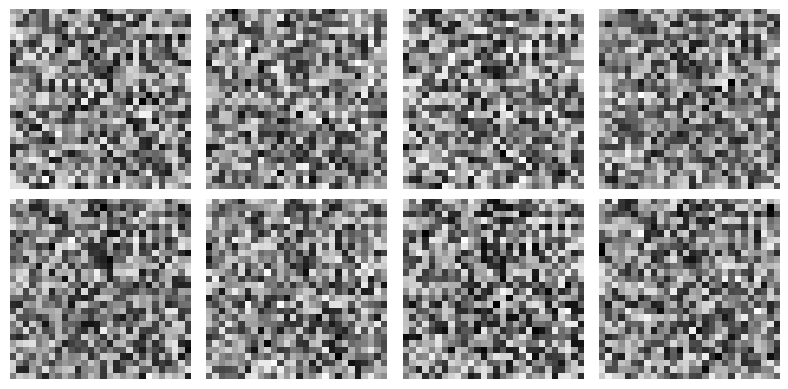

In [77]:
loop = 20

def train():
    init()
    training(loop)
    test_gen(2, 4)


train()